#**⚛️ Quantum Plinko (qPlinko) 💸**


⚜️ **Author:** Sibishan Ravindran

---

In [ ]:
#install this to draw pretty quantum circuits
!pip install qiskit --quiet
!pip install pylatexenc --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# to draw the plinko board & graphs
import matplotlib.pyplot as plt
from itertools import product

# to calculate the probabilities
import numpy as np
from math import comb

# to visualise quantum circuits
from qiskit import QuantumCircuit
from qiskit.visualization import plot_bloch_multivector, circuit_drawer

## 🎰 Classical Plinko: The Game Before It Got Quantum

Plinko is a classic game of chance that involves dropping a ball from the top of a triangular peg board. As the ball descends, it hits pegs and randomly bounces either **left** or **right** at each level. Eventually, the ball lands in one of the slots at the bottom.

This randomness creates an exciting, yet entirely classical, probability game.

<img src="https://media.tenor.com/klkckiLg6e4AAAAM/plinko-stake.gif" alt="Stake Plinko Game" />


### 🧠 How It Works

To make my life easier, I got rid of the  **physics** of a falling ball. 😅

Instead of simulating gravity, collisions, and angles like in a real Plinko game, we assume that **each peg introduces a perfectly fair 50/50 chance** — a coin flip — of the ball going **left** or **right**.

#### 🟢 Ball Movement

- Each row contains pegs, and the ball hits one peg per row.
- At every peg, the ball randomly bounces **left** (denoted as `0`) or **right** (`1`).
- For $(n)$ rows, the ball makes $(n)$ binary decisions, resulting in a bitstring like:

$$
\text{Bitstring} = b_1b_2b_3\ldots b_n \quad \text{where } b_i \in \{0, 1\}
$$


#### 🕳️ Final Slot

The final slot is determined by the **number of right bounces** in the path.

$$
\text{Final Slot} = \sum_{i=1}^{n} b_i
$$

$$
\text{Slot}_{\text{index}} = k + 1 \quad \text{where } k = \text{number of 1s in the bitstring}
$$

So, for a path like `010`, the ball made **1 right turn**, and lands in **Slot 2**.

Since the ball can go right anywhere from 0 to $(n)$ times, there are a total of:

$$
n + 1 \text{ final slots}
$$

For example:
- 3 rows → 4 slots (Slot 1 to Slot 4)
- 5 rows → 6 slots (Slot 1 to Slot 6)


##### ${\small \textsf{Expand the code cell below to see the visualisation of paths that can be taken.}}$




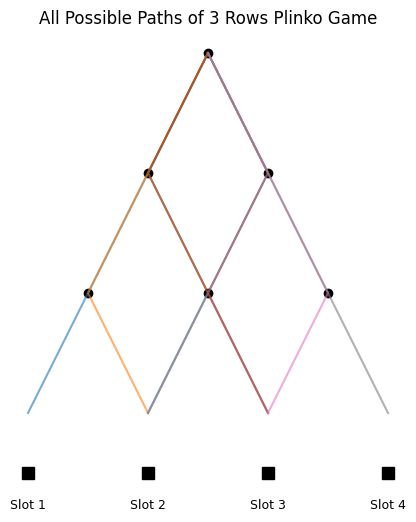

In [3]:
def get_path_coords(bitstring):
    x, y = 0, 0  # start at top center
    path = [(x, y)]
    for b in bitstring:
        y -= 1  # move down one row
        x += 0.5 if b == '1' else -0.5  # move left or right
        path.append((x, y))
    return path

def draw_all_physical_plinko_paths(num_rows=3):
    fig, ax = plt.subplots(figsize=(6, 6))

    # Draw pegs
    for row in range(num_rows):
        y = -row
        for col in range(row + 1):
            x = col - row / 2
            ax.plot(x, y, 'ko', markersize=6)

    # Draw slots
    slot_y = -num_rows - 0.5
    for i in range(num_rows + 1):
        x = i - num_rows / 2
        ax.plot(x, slot_y, 'ks', markersize=8)
        ax.text(x, slot_y - 0.3, f'Slot {i + 1}', ha='center', fontsize=9)

    # Generate all possible paths
    all_paths = [''.join(p) for p in product('01', repeat=num_rows)]

    # Draw each path
    for path in all_paths:
        coords = get_path_coords(path)
        xs, ys = zip(*coords)
        ax.plot(xs, ys, alpha=0.6)

    ax.set_title(f"All Possible Paths of {num_rows} Rows Plinko Game")
    ax.set_aspect('equal')
    ax.axis('off')
    plt.show()

# Run it
draw_all_physical_plinko_paths(num_rows=3)

### 📊 Why Balls Tend to Land in the Center

Although each bounce is 50/50, **not all final slots are equally likely**. The central slots have more combinations of left/right sequences that lead to them — a property of the **binomial distribution**.

For example, with 4 rows:
- Only 1 path leads to the far-left slot
- But **6 paths** lead to the middle slots

The probability of landing in slot $( k )$ is given by:

$$
P(k) = \binom{n}{k} \left(\frac{1}{2}\right)^k \left(\frac{1}{2}\right)^{n-k} = \binom{n}{k} \left(\frac{1}{2}\right)^n
$$

##### ${\small \textsf{Expand the code cell below to see the visualisation of distribution.}}$

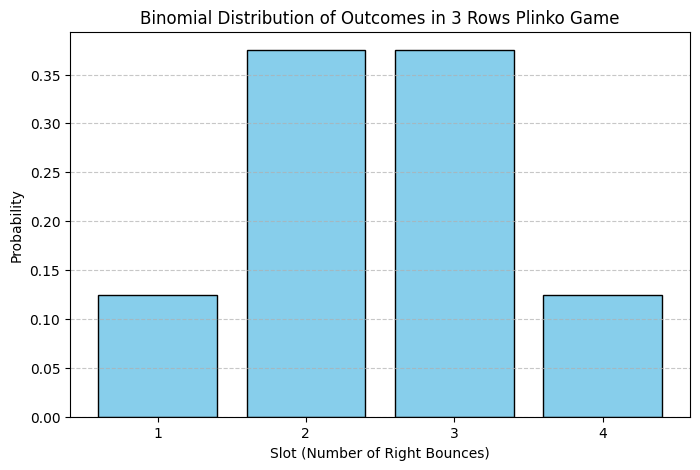

In [4]:
def plot_binomial_distribution(n_rows):
    slots = np.arange(1, n_rows + 2)
    probabilities = [comb(n_rows, k - 1) * (0.5)**n_rows for k in slots]

    plt.figure(figsize=(8, 5))
    plt.bar(slots, probabilities, color='skyblue', edgecolor='black')
    plt.xticks(slots)
    plt.xlabel("Slot (Number of Right Bounces)")
    plt.ylabel("Probability")
    plt.title(f"Binomial Distribution of Outcomes in {n_rows} Rows Plinko Game")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example: 7 rows = 8 slots
plot_binomial_distribution(n_rows=3)


---

### 💸 Classical Gambling Logic

In traditional Plinko, players bet on where a single ball will land.

#### 🎮 How to Play

- The player starts with a **total balance** (e.g., $1,000,000).
- Before each drop, the player:
  - Assigns a **value to the ball** they’re about to drop (the stake).
  - Selects a **risk level**, which determines how payouts are distributed across slots.
  - Selects a **number of rows**, which determines how many bounces the ball will make and how many slots it can land in.
- The ball falls through the Plinko board and lands in one of the slots.
- Each slot has a **multiplier** based on its rarity:
  - **Center slots** are common → lower multipliers (e.g., 0.5×)
  - **Edge slots** are rare → higher multipliers (e.g., 100×)


#### 🧮 Payout Formula

Each time a ball is dropped, its outcome depends on:
- The **value** the player assigns to the ball
- The **slot** the ball lands in
- The **multiplier** associated with that slot (based on risk level)


For each individual ball:

$$
\text{Payout}_i = \text{Ball Value}_i \times \text{Slot Multiplier}_i
$$

After the ball is dropped, the player's balance is updated as:

$$
\text{Balance}_{\text{new}} = \text{Balance}_{\text{previous}} - \text{Ball Value}_i + \text{Payout}_i
$$


#### 🏦 Game Progression

- The player may continue **dropping balls one at a time**.
- After each round, they can decide to:
  - Drop another ball, or
  - **Stop the game** and keep their remaining balance.
- The game ends automatically when the player **runs out of money**.


---


## 🚀 Making it Quantum

In this game, instead of using traditional randomness (like Python’s random module), we use **quantum bits (qubits)** to simulate uncertainty and randomness in the Plinko board.

Qubits, unlike classical bits (which are either 0 or 1), can exist in a **superposition** — a combination of both states at once. This allows us to model the ball’s decision at each peg using **quantum randomness**, rather than just simulating it classically.

In quantum information, the state of a qubit can be represented as a **vector**:

$$
|\psi\rangle =
\begin{pmatrix}
\psi_0 \\
\psi_1
\end{pmatrix}
$$

In the **computational basis**, we define the two basic states as:

$$
|0\rangle =
\begin{pmatrix}
1 \\
0
\end{pmatrix}, \quad
|1\rangle =
\begin{pmatrix}
0 \\
1
\end{pmatrix}
$$

A qubit can exist in a **superposition** of both, written as:

$$
|\psi\rangle = \psi_0 |0\rangle + \psi_1 |1\rangle
$$

Each row of the Plinko board corresponds to a **quantum decision**, modeled by a **qubit** in a quantum circuit.

- A **qubit** can exist in a superposition of both left and right at once.
- We use a **Hadamard gate** on each qubit to create a perfect 50/50 superposition:
  
$$ H = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix} $$

- When measured, each qubit **collapses** to either $(0)$ (left) or $(1)$ (right), just like a ball bouncing left or right at a peg.

### 🌶️ Entangled Balls Option (Spicing It Up! 🥵)

In this game, players have the option to drop **entangled balls** — a feature inspired by one of the most fascinating phenomena in quantum mechanics: **entanglement**.

Entanglement is a quantum effect where two or more qubits become **correlated in such a way that the state of one instantly affects the other**, no matter how far apart they are. Once entangled, the measurement of one qubit will directly influence the outcome of the other.

#### 🎮 How It Works in the Game

- When the **Entangled Balls** option is enabled, two quantum balls are dropped simultaneously.
- Each ball has its own set of qubits (representing rows), but corresponding qubits are **entangled** using a **CNOT gate** after applying a **Hadamard gate**.
$$
\text{CNOT}|q_1, q_2\rangle =
\begin{cases}
|0, q_2\rangle & \text{if } q_1 = 0 \\
|1, \overline{q_2}\rangle & \text{if } q_1 = 1
\end{cases}
$$
- This means the paths of the two balls become **quantum-linked** — their bounces are no longer fully independent (double the risk, double the reward).


#### 🧠 How We Entangle the Qubits

For each row $( i )$:

1. Apply a **Hadamard gate** to qubit $( q_A[i] )$:

$$
H|0\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)
$$

2. Then apply a **CNOT gate** from $( q_A[i] )$ (control) to $( q_B[i] )$ (target), creating:

$$
|\psi\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)
$$

This is a **Bell state**, one of the simplest forms of quantum entanglement. It means both qubits will always collapse to the **same value** when measured — either both `0` or both `1`.

#### 👾 What It Means Physically

- Ball A and Ball B will take **synchronized paths** — either both bounce left at a peg or both bounce right.
- To visually distinguish them, We **invert Ball B’s path** (flip all bits) before rendering it, creating a mirrored effect.
- This maintains the quantum correlation while enhancing gameplay visuals.

💡 **Just for Fun!**  
Okay, okay... we *know* that once the qubits are entangled, both balls are going to take the same exact path — it’s quantum physics, not magic. 😄  
But to demonstrate this mysterious and powerful concept of **entanglement**, we’ll still implement it — because what's the point of quantum wizardry if you can't show off a little? ✨🧙‍♂️


---

## 📟 Quantum Hardware (🦫 Quokka Quantum Simulator)

To bring the qPlinko to life, this game uses a **quantum circuits** to generate randomness and simulate quantum behavior. Specifically, we use the **Quokka Quantum Simulator**, which allows us to construct and execute real quantum circuits without needing access to a physical quantum computer.

<img src="https://miro.medium.com/v2/resize:fit:1360/0*h374mY5MwsbWcsv_" alt="quokka" />

---

## 🔩 Building the Quantum Circuit

Instead of simulating the ball row by row (and DDoS-ing Quokka with too many requests 😅), we calculate the full path of the ball in a single quantum circuit execution when it begins to fall.


- For $(n)$ rows, we use $(n)$ qubits.
- We apply a Hadamard gate to each qubit.
- Then we measure all qubits to obtain a binary string like `"0101"`, representing the full path of the ball.
- The number of 1's in the bitstring tells us the final **slot** in the Plinko board.

Below is the visualisation of quantum circuit for 3 rows qPlinko game.




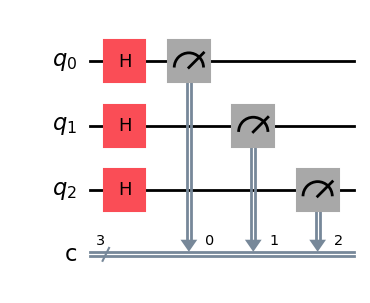

In [5]:
num_rows = 3  # 3 rows are easy to visualise

qc_single = QuantumCircuit(num_rows, num_rows)
for i in range(num_rows):
    qc_single.h(i)
    qc_single.measure(i, i)

qc_single.draw('mpl')

Below is the visualisation of quantum circuit for 3 rows qPlinko game with 2 Entangled Balls.

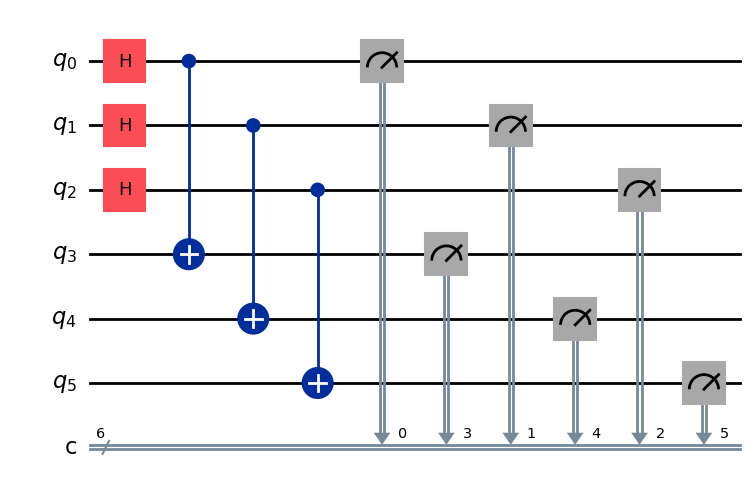

In [6]:
qc_entangled = QuantumCircuit(2 * num_rows, 2 * num_rows)
for i in range(num_rows):
    qc_entangled.h(i)  # Ball A
    qc_entangled.cx(i, i + num_rows)  # Entangle with Ball B
    qc_entangled.measure(i, i)
    qc_entangled.measure(i + num_rows, i + num_rows)

qc_entangled.draw('mpl')

## 🧱 Building qPlinko



###  ⚙️ Setting Up the Environment

In [7]:
# Install UI Packages
!pip install ipywidgets ipycanvas --quiet

# Import math libraries
import numpy as np
import math

#Import Data handling and communication
import json
import requests

# For Concurrency
import asyncio

# For Visualisation
import matplotlib.pyplot as plt

# Import UI Libraries
from ipywidgets import VBox, HBox, Button, IntText, Dropdown, Checkbox, HTML, Output
from ipycanvas import Canvas, hold_canvas
from IPython.display import display, clear_output

# Suppress warnings for cleaner output
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

# Enable custom widget support in Colab
from google.colab import output
output.enable_custom_widget_manager()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.0 MB/s eta 0:00:00


### 🦫 Quokka Helper Function

In [8]:
def send_to_quokka(program, quokka_node='quokka3'):  # quokka_node is a keyword argument with a default value of quokka3
    # Step 1: Define the server address
    request_http = 'http://{}.quokkacomputing.com/qsim/qasm'.format(quokka_node)

    # Step 2: Prepare the data to send
    data = {
        'script': program,
        'count': 1
    }

    # Step 3: Send the POST request
    result = requests.post(request_http, json=data, verify=False)

    # Step 4: Convert the response to a Python dictionary
    json_obj = json.loads(result.content)

    # Return the result
    return json_obj['result']['c']

#### 🧪 Quokka Tester Function

In [9]:
def test_quokka_nodes():
    working_quokkas = []

    # A simple quantum coin flip: puts qubit in superposition and measures it (0 or 1).
    test_program = """
    OPENQASM 2.0;
    include "qelib1.inc";

    qreg q[1];
    creg c[1];

    h q[0];
    measure q[0] -> c[0];
    """

    # Quick test all Quokka nodes (1 to 6) and logging the responsive ones.
    print("🔍 Testing Quokka nodes...\n")
    for i in range(1, 7):
        node = f"quokka{i}"
        try:
            result = send_to_quokka(test_program, node)
            if result:
                print(f"✅ {node} is responding — result: {result}")
                working_quokkas.append(node)
            else:
                print(f"⚠️  {node} responded but no result.")
        except Exception as e:
            print(f"❌ {node} failed — {str(e)}")

    print("\n✅ Working Quokkas:", working_quokkas)

test_quokka_nodes()

🔍 Testing Quokka nodes...

✅ quokka1 is responding — result: [[0]]
✅ quokka2 is responding — result: [[0]]
✅ quokka3 is responding — result: [[1]]
❌ quokka4 failed — Expecting value: line 1 column 1 (char 0)
✅ quokka5 is responding — result: [[0]]
✅ quokka6 is responding — result: [[0]]

✅ Working Quokkas: ['quokka1', 'quokka2', 'quokka3', 'quokka5', 'quokka6']


##### ⚠️ Only Quokka 3 to 5 working as of 26/03/2025

### 📝 Quantum Program Generator Function

I know, I know... I *could have* used **Qiskit**, **Cirq**, or **PennyLane** to generate the QASM programs for the game.  
But I actually wrote this quantum logic manually back in **Week 3**, and started integrating it into the game early on.

I'm still experimenting with Qiskit on the side — but as the classic programming wisdom goes:

> <img src="https://img.devrant.com/devrant/rant/r_2371373_Bmdde.jpg" alt="meme"/>



In [10]:
# Generates an OpenQASM 2.0 quantum circuit for a single or entangled Plinko
def generate_qplinko_qasm(num_rows, entangled=False):
    qasm = ["OPENQASM 2.0;",
            'include "qelib1.inc";']                                            # Initialize QASM with version and standard library

    if entangled:
        qasm.append(f"qreg q[{2 * num_rows}];")                                 # Create 2 * n qubits for both entangled balls
        qasm.append(f"creg c[{2 * num_rows}];")                                 # Create 2 * n classical registers for measurement results
        for i in range(num_rows):
            qasm.append(f"h q[{i}];")                                           # Apply Hadamard gate to ball A
            qasm.append(f"cx q[{i}], q[{i + num_rows}];")                       # Entangle ball A and B qubits using CNOT Gate
            qasm.append(f"measure q[{i}] -> c[{i}];")                           # Measure ball A qubit
            qasm.append(f"measure q[{i + num_rows}] -> c[{i + num_rows}];")     # Measure ball B qubit
    else:
        qasm.append(f"qreg q[{num_rows}];")                                     # Create n qubits for a single ball
        qasm.append(f"creg c[{num_rows}];")                                     # Create n classical registers for measurement results
        for i in range(num_rows):
            qasm.append(f"h q[{i}];")                                           # Apply Hadamard gate to simulate a coin flip at each peg
            qasm.append(f"measure q[{i}] -> c[{i}];")                           # Measure result into classical register

    return "\n".join(qasm)                                                      # Return the complete QASM program by joining the array into a string
                                                                                # Instead of messy string manulplation


### ▶️ Quantum Program Execution Function

In [11]:
def drop_ball(num_rows, entangled=False, quokka_node="quokka3"):
    qasm = generate_qplinko_qasm(num_rows, entangled)                           # generate QASM code to send to Quokka
    raw_result = send_to_quokka(qasm, quokka_node=quokka_node)                    # send QASM code to Quokka and get ball/s path/s

    if not raw_result:
        return None                                                             # returns null object when Quokka fails

    if entangled:
        half = len(raw_result[0]) // 2
        return [raw_result[0][:half], raw_result[0][half:]]                     # Split bitstring into Ball A and B and return 2 lists to caller
    else:
        return [raw_result[0]]                                                  # return 1 list of bitsring of ball path to caller

### 🔍 Slot Finder Function

In [12]:
def bitstring_to_slot(bitstring):
    return bitstring.count(1)                                                   # counts number of 1s in the given list


#### 🧪 Quantum Game Logic Testing

In [13]:
result = drop_ball(num_rows=7, entangled=True)

print(result)

if result:
    bit_a, bit_b = result
    slot_a = bitstring_to_slot(bit_a)
    slot_b = bitstring_to_slot(bit_b)

    print(f"Ball A Path: {[int(b) for b in bit_a]} → Slot {slot_a}")
    print(f"Ball B Path: {[int(b) for b in bit_b]} → Slot {slot_b}")


[[1, 1, 0, 1, 0, 1, 1], [1, 1, 0, 1, 0, 1, 1]]
Ball A Path: [1, 1, 0, 1, 0, 1, 1] → Slot 5
Ball B Path: [1, 1, 0, 1, 0, 1, 1] → Slot 5


### 🧩 Game Logic Functions

In [14]:
def get_slot_multipliers(risk_level='Medium', num_rows=13):
    multipliers = {
        9: {  # 10 slots
            'Low':    [10, 5, 2, 0.8, 0.5, 0.5, 0.8, 2, 5, 10],
            'Medium': [100, 10, 2, 0.5, 0.3, 0.3, 0.5, 2, 10, 100],
            'High':   [1000, 50, 5, 0.3, 0.3, 0.3, 0.3, 5, 50, 1000]
        },
        11: {  # 12 slots
            'Low':    [10, 5, 2.5, 1.5, 0.8, 0.5, 0.5, 0.8, 1.5 , 2.5, 5, 10],
            'Medium': [100, 10, 5, 2, 0.5, 0.3, 0.3, 0.5, 2, 5, 10, 100],
            'High':   [1000, 50, 5, 2.5, 0.5, 0.3, 0.3, 0.5, 2.5, 5, 50, 1000]
        },
        13: {  # 14 slots
            'Low':    [10, 7, 4, 2, 1.5, 0.8, 0.5, 0.5, 0.8, 1.5, 2, 4, 7, 10],
            'Medium': [100, 10, 6, 3, 1.5, 0.6, 0.3, 0.3, 0.6, 1.5, 3, 6, 10, 100],
            'High':   [1000, 100, 10, 5, 2, 0.5, 0.2, 0.2, 0.5, 2, 5, 10, 100, 1000]
        }
    }

    # Return appropriate slot multipliers
    if num_rows in multipliers and risk_level in multipliers[num_rows]:
        return multipliers[num_rows][risk_level]
    else:
        raise ValueError("Invalid combination of num_rows or risk_level")


def calculate_payout(ball_value, slot_index, multipliers):
    if 0 <= slot_index < len(multipliers):                                      # Check if slot index is valid
        multiplier = multipliers[slot_index]                                    # Get multiplier for the slot
        payout = round(ball_value * multiplier, 2)                              # Calculate payout based on multiplier
        return payout
    else:
        print(f"⚠️ Invalid slot index: {slot_index}")                           # Error message for invalid slot index
        return 0.0


def update_balance(game_state, bet_amount, payout):
    net = round(payout - bet_amount, 2)                                         # Net profit/loss from the bet
    game_state["balance"] = round(game_state["balance"] + net, 2)               # Update player's balance
    game_state["player_profit"] += net                                          # Track player's total profit/loss
    game_state["house_profit"] += round(-net, 2)                                # Opposite of player profit/loss

    return net



### 🎨 Game Visualisations Functions

In [15]:
# Draw the Plinko board with pegs and slot multipliers
def draw_plinko_board(num_rows=9, risk_level='Medium'):
    board_canvas.clear()
    peg_radius = 4
    spacing_x = canvas_width / (num_rows + 2)
    vertical_spacing = (canvas_height - 100) / (num_rows + 2)

    # Get multipliers based on risk level
    multipliers = get_slot_multipliers(risk_level, num_rows)

    # --- Draw Pegs (Centered) ---
    board_canvas.fill_style = 'white'
    for row in range(num_rows):
        y = 50 + row * vertical_spacing
        num_pegs = row + 1
        row_width = (num_pegs - 1) * spacing_x
        start_x = (canvas_width - row_width) / 2

        for col in range(num_pegs):
            x = start_x + col * spacing_x
            board_canvas.fill_circle(x, y, peg_radius)

    # --- Draw Slots + Labels ---
    y_slot = 50 + num_rows * vertical_spacing + 20
    num_slots = num_rows + 1
    total_slot_width = (num_slots - 1) * spacing_x
    start_x = (canvas_width - total_slot_width) / 2

    for i in range(num_slots):
        x = start_x + i * spacing_x

        # Draw slot box
        board_canvas.fill_style = 'blue'
        board_canvas.fill_rect(x - 10, y_slot, 20, 20)

        # Slot number
        board_canvas.fill_style = 'white'
        board_canvas.font = '12px sans-serif'
        board_canvas.fill_text(str(i+1), x - 3, y_slot + 35)

        # Multiplier label - Better centering
        board_canvas.fill_style = 'yellow'
        board_canvas.font = '12px sans-serif'
        mult_text = f"x{multipliers[i]}"
        text_width = len(mult_text) * 6                                         # Estimate text width
        board_canvas.fill_text(mult_text, x - text_width/2, y_slot + 50)

    # --- Title ---
    board_canvas.fill_style = 'white'
    board_canvas.font = '16px sans-serif'
    board_canvas.fill_text("qPlinko", 10, 20)


# Animate Ball A (and optionally entangled Ball B) using path lines.
# Ball B is mirrored across the vertical center.
async def animate_path_line(bitstring_a, bitstring_b=None, color_a='cyan', color_b='magenta', delay=0.1):
    draw_plinko_board(len(bitstring_a), risk_dropdown.value)  # Redraw board

    spacing_x = canvas_width / (len(bitstring_a) + 2)
    spacing_y = (canvas_height - 100) / (len(bitstring_a) + 2)

    def get_path_points(bits, mirror=False):
        points = []
        x = canvas_width / 2
        y = 30
        offset = 0
        for bit in bits:
            y += spacing_y
            offset += 1 if bit == 1 else -1
            dx = offset * spacing_x / 2
            new_x = canvas_width / 2 + (-dx if mirror else dx)
            points.append((new_x, y))
        return points

    # Compute both paths
    points_a = get_path_points(bitstring_a)
    points_b = get_path_points(bitstring_b, mirror=True) if bitstring_b else []

    # --- Animate Path A ---
    x0, y0 = canvas_width / 2, 50
    board_canvas.stroke_style = color_a
    board_canvas.line_width = 3

    # Draw ball at starting position
    board_canvas.fill_style = color_a
    board_canvas.fill_circle(x0, y0, 8)
    await asyncio.sleep(delay)

    # Animate the path
    board_canvas.begin_path()
    board_canvas.move_to(x0, y0)

    for i, (x, y) in enumerate(points_a):
        board_canvas.line_to(x, y)
        with hold_canvas(board_canvas):
            board_canvas.stroke()
            # Draw the ball at current position
            board_canvas.fill_circle(x, y, 8)
        await asyncio.sleep(delay)

    # --- Animate Path B (entangled) ---
    if points_b:
        x0, y0 = canvas_width / 2, 50
        board_canvas.stroke_style = color_b
        board_canvas.fill_style = color_b

        # Draw ball at starting position
        board_canvas.fill_circle(x0, y0, 8)
        await asyncio.sleep(delay)

        # Animate the path
        board_canvas.begin_path()
        board_canvas.move_to(x0, y0)

        for i, (x, y) in enumerate(points_b):
            board_canvas.line_to(x, y)
            with hold_canvas(board_canvas):
                board_canvas.stroke()
                # Draw the ball at current position
                board_canvas.fill_circle(x, y, 8)
            await asyncio.sleep(delay)

### 🛠️ Set up UI Components

In [16]:
# Initialize game state
game_state = {
    "balance": 1_000_000,
    "house_profit": 0.0,
    "player_profit": 0.0,
    "history": []
}

# Canvas setup
canvas_width = 500
canvas_height = 600
board_canvas = Canvas(width=canvas_width, height=canvas_height)
board_canvas.layout.height = f"{canvas_height}px"
board_canvas.layout.margin = "20px 0 0 0"

# ----- UI Components -----

# 🎯 Bet Input
bet_input = IntText(value=1000, description="Bet per Ball:", layout={'width': '95%'})

# 🎲 Risk Level Dropdown
risk_dropdown = Dropdown(
    options=["Low", "Medium", "High"],
    value="Medium",
    description="Risk Level:",
    layout={'width': '60%'}
)

# 🧱 Rows Dropdown
row_dropdown = Dropdown(
    options=[9, 11, 13],
    value=9,
    description="Rows:",
    layout={'width': '60%'}
)

# 🔗 Entangled Toggle
entangle_checkbox = Checkbox(description="Entangled Balls")
entangle_checkbox.layout.margin = '28px 0 0 10px'

# 🎮 Game Buttons
drop_button = Button(description="🎯 Drop Ball", button_style="success", layout={'width': '32%'})
stop_button = Button(description="🔴 Stop Game", button_style="danger", layout={'width': '32%'})
reset_button = Button(description="🔁 Reset Game", button_style="info", layout={'width': '32%'})

# 💰 Balance + 📢 Status
balance_display = HTML(f"<b>Balance:</b> ${game_state['balance']:,.0f}")
balance_display.layout.margin = '10px 0 0 0'

game_status = HTML("<b>Status:</b> Ready to play.")
game_status.layout.margin = '5px 0 0 0'

# ----- Layout -----
ui_controls = VBox([
    bet_input,
    HBox([risk_dropdown, entangle_checkbox]),
    row_dropdown,
    HBox([drop_button, stop_button, reset_button]),
    balance_display,
    game_status
])

ui_controls.layout.width = '100%'
ui_controls.layout.padding = '10px'

### 🕹 Implement Game Handlers

In [17]:
# Handler for dropping a ball
def on_drop_button_click(b):
    # Disable button to prevent multiple clicks
    drop_button.disabled = True
    game_status.value = "<b>Status:</b> Running quantum drop..."

    # Fetch current user settings from UI
    bet = bet_input.value
    num_rows = row_dropdown.value
    risk_level = risk_dropdown.value
    entangled = entangle_checkbox.value

    # Validate bet amount
    if bet <= 0:
        game_status.value = "<b>Status:</b> ❌ Invalid bet amount."
        drop_button.disabled = False
        return

    if bet > game_state["balance"]:
        game_status.value = "<b>Status:</b> ❌ Not enough balance."
        drop_button.disabled = False
        return

    try:
        # Run the quantum program on a selected Quokka node
        quantum_result = drop_ball(num_rows, entangled, quokka_node="quokka3")

        # Handle missing result
        if quantum_result is None:
            game_status.value = "<b>Status:</b> ❌ Quantum computation failed on Quokka node."
            drop_button.disabled = False
            return

        # Convert the QASM binary results to bits
        bitstrings = []
        for result in quantum_result:
            bits = [int(bit) for bit in result]
            bitstrings.append(bits)

    except Exception as e:
        # If quantum computation fails, show error message
        game_status.value = f"<b>Status:</b> ❌ Quantum computation failed: {str(e)}"
        drop_button.disabled = False
        return

    # Draw the paths manually instead of animating
    draw_plinko_board(num_rows, risk_level)

    # Draw the paths
    spacing_x = canvas_width / (num_rows + 2)
    spacing_y = (canvas_height - 100) / (num_rows + 2)

    # Define path points for each ball
    def get_path_points(bits, mirror=False):
        points = []
        x = canvas_width / 2
        y = 30
        offset = 0
        for bit in bits:
            y += spacing_y
            offset += 1 if bit == 1 else -1
            dx = offset * spacing_x / 2
            new_x = canvas_width / 2 + (-dx if mirror else dx)
            points.append((new_x, y))
        return points

    # Draw the paths
    points_a = get_path_points(bitstrings[0])
    board_canvas.stroke_style = 'cyan'
    board_canvas.line_width = 3
    board_canvas.begin_path()
    x0, y0 = canvas_width / 2, 30
    board_canvas.move_to(x0, y0)
    for x, y in points_a:
        board_canvas.line_to(x, y)
    board_canvas.stroke()

    # Draw ball A at final position
    board_canvas.fill_style = 'cyan'
    board_canvas.fill_circle(points_a[-1][0], points_a[-1][1], 8)

    # Draw ball B if entangled
    if entangled and len(bitstrings) > 1:
        points_b = get_path_points(bitstrings[1], mirror=True)
        board_canvas.stroke_style = 'magenta'
        board_canvas.begin_path()
        board_canvas.move_to(x0, y0)
        for x, y in points_b:
            board_canvas.line_to(x, y)
        board_canvas.stroke()

        # Draw ball B at final position
        board_canvas.fill_style = 'magenta'
        board_canvas.fill_circle(points_b[-1][0], points_b[-1][1], 8)

    # Calculate results and update balance
    multipliers = get_slot_multipliers(risk_level, num_rows)
    total_payout = 0
    total_bet = bet * len(bitstrings)

    result_text = ""
    for i, bits in enumerate(bitstrings):
        slot_index = sum(1 for b in bits if b == 1)  # Count 1s to get slot index
        ball_name = "Ball A" if i == 0 else "Ball B"
        payout = calculate_payout(bet, slot_index, multipliers)
        total_payout += payout

        result_text += f"{ball_name}: Slot {slot_index} (x{multipliers[slot_index]}) → ${payout:,.2f}<br>"

    # Update game state
    net_profit = total_payout - total_bet
    game_state["balance"] += net_profit
    game_state["player_profit"] += net_profit
    game_state["house_profit"] -= net_profit

    # Add to history
    game_state["history"].append({
        "bet": total_bet,
        "payout": total_payout,
        "net": net_profit,
        "risk_level": risk_level,
        "entangled": entangled
    })

    # Update UI
    balance_display.value = f"<b>Balance:</b> ${game_state['balance']:,.2f}"

    if net_profit >= 0:
        result_message = f"🎉 Won ${net_profit:,.2f}!"
    else:
        result_message = f"😢 Lost ${-net_profit:,.2f}"

    game_status.value = f"<b>Status:</b> {result_message}<br>{result_text}"
    drop_button.disabled = False

# Connect the button to the handler
drop_button.on_click(on_drop_button_click)

# Handler for stopping the game
def stop_game_handler(b):
    drop_button.disabled = True

    # Calculate profit/loss
    profit = game_state["balance"] - 1_000_000

    if profit > 0:
        message = f"🎉 Game over! You made ${profit:,.2f} profit!"
    else:
        message = f"😢 Game over! You lost ${-profit:,.2f}."

    game_status.value = f"<b>Status:</b> {message}"

    # Update final stats
    balance_display.value = f"<b>Balance:</b> ${game_state['balance']:,.2f}"

# Handler for resetting the game
def reset_game_handler(b):
    global game_state

    game_state = {
        "balance": 1_000_000,
        "house_profit": 0.0,
        "player_profit": 0.0,
        "history": []
    }

    drop_button.disabled = False
    stop_button.disabled = False

    balance_display.value = f"<b>Balance:</b> ${game_state['balance']:,.0f}"
    game_status.value = "<b>Status:</b> Ready to play."

    # Redraw the board
    draw_plinko_board(num_rows=row_dropdown.value, risk_level=risk_dropdown.value)

# Settings change handler
def on_setting_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        draw_plinko_board(num_rows=row_dropdown.value, risk_level=risk_dropdown.value)

# Attach observers and event handlers
drop_button.on_click(on_drop_button_click)
stop_button.on_click(stop_game_handler)
reset_button.on_click(reset_game_handler)
risk_dropdown.observe(on_setting_change)
row_dropdown.observe(on_setting_change)

### Display the Game

In [18]:
# Function to display the full interface
def start_game():
    game_layout = VBox([ui_controls, board_canvas])
    display(ui_controls)
    display(board_canvas)


    # Initialize the board with current settings
    draw_plinko_board(num_rows=row_dropdown.value, risk_level=risk_dropdown.value)

    # Welcome message
    game_status.value = """<b>Status:</b> Welcome to Quantum Plinko!
    <br>• Choose your settings and click 'Drop Ball' to play
    <br>• Each ball follows a quantum path determined by Hadamard gates
    <br>• Entangled Balls use quantum entanglement to create mirrored paths"""

### ▶ Start Game

⚖️ Entangled Balls = Double the Reward, Double the Risk
When you drop two entangled balls, you’re betting on quantum harmony — if it goes well, it really goes well... and if not, well... the house says thanks! 😅

⚠️ Entangled Balls for 13 rows take a bit longer to execute (about 40 seconds)

⚠️ If things freeze up, just give it the ol’ reboot! Restart the session — even quantum magic needs a fresh start sometimes. 🔄✨

In [19]:
# ⚠️ Make Sure That You Executed All Cells Before Executing This Cell
start_game()

Canvas(height=600, layout=Layout(height='600px', margin='20px 0 0 0'), width=500)

### 📊 Gameplay Analysis

Time to put on our data-analyst hats! 🕵🏻  
Let’s analyze how the game performed — player profit, house edge, lucky streaks, and quantum chaos.  
Below you’ll find some juicy stats and visualizations from your epic qPlinko sessions!

In [20]:
def analyze_game_data():
    if not game_state["history"]:
        print("No game data available. Play the game first!")
        return

    # Print overall statistics
    print("=" * 50)
    print("QUANTUM PLINKO GAME ANALYSIS")
    print("=" * 50)

    # Calculate overall stats
    total_bets = len(game_state["history"])
    total_bet_amount = sum(item["bet"] for item in game_state["history"])
    total_payout = sum(item["payout"] for item in game_state["history"])
    net_profit = total_payout - total_bet_amount
    win_rate = sum(1 for item in game_state["history"] if item["net"] > 0) / total_bets if total_bets > 0 else 0

    print(f"Starting Balance: ${1_000_000:,.2f}")
    print(f"Current Balance: ${game_state['balance']:,.2f}")
    print(f"Total Bets Made: {total_bets}")
    print(f"Total Bet Amount: ${total_bet_amount:,.2f}")
    print(f"Total Payouts: ${total_payout:,.2f}")
    print(f"Net Profit/Loss: ${net_profit:,.2f} ({'profit' if net_profit >= 0 else 'loss'})")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"House Profit: ${game_state['house_profit']:,.2f}")
    print(f"Player Profit: ${game_state['player_profit']:,.2f}")
    print("=" * 50)

    # Print detailed bet history
    print("\nDETAILED BET HISTORY")
    print("-" * 80)
    print(f"{'#':^5}|{'Bet Amount':^15}|{'Payout':^15}|{'Net':^15}|{'Risk Level':^12}|{'Entangled':^10}")
    print("-" * 80)

    for i, bet in enumerate(game_state["history"]):
        net_str = f"${bet['net']:,.2f}"
        if bet['net'] > 0:
            net_str = f"+{net_str}"
        print(f"{i+1:^5}|${bet['bet']:,.2f}^15|${bet['payout']:,.2f}^15|{net_str:^15}|{bet['risk_level']:^12}|{'Yes' if bet['entangled'] else 'No':^10}")

    print("-" * 80)

    # Create visualizations
    try:
        plt.figure(figsize=(15, 10))

        # Plot 1: Cumulative profit/loss over time
        plt.subplot(2, 2, 1)
        cumulative_profit = [0]
        for bet in game_state["history"]:
            cumulative_profit.append(cumulative_profit[-1] + bet["net"])

        plt.plot(range(len(cumulative_profit)), cumulative_profit, 'b-', linewidth=2)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Cumulative Profit/Loss Over Time')
        plt.xlabel('Number of Bets')
        plt.ylabel('Profit/Loss ($)')
        plt.grid(True)

        # Plot 2: Performance by risk level
        plt.subplot(2, 2, 2)
        risk_levels = ['Low', 'Medium', 'High']
        risk_profits = []
        risk_counts = []

        for risk in risk_levels:
            bets = [bet for bet in game_state["history"] if bet["risk_level"] == risk]
            risk_profits.append(sum(bet["net"] for bet in bets))
            risk_counts.append(len(bets))

        plt.bar(risk_levels, risk_profits, color=['green', 'blue', 'red'])
        plt.title('Profit/Loss by Risk Level')
        plt.xlabel('Risk Level')
        plt.ylabel('Profit/Loss ($)')
        for i, v in enumerate(risk_profits):
            plt.text(i, v + (1 if v >= 0 else -1), f"${v:,.2f}", ha='center')

        # Plot 3: Entangled vs Non-entangled performance
        plt.subplot(2, 2, 3)
        entangled_bets = [bet for bet in game_state["history"] if bet["entangled"]]
        non_entangled_bets = [bet for bet in game_state["history"] if not bet["entangled"]]

        entangled_profit = sum(bet["net"] for bet in entangled_bets)
        non_entangled_profit = sum(bet["net"] for bet in non_entangled_bets)

        plt.bar(['Entangled', 'Non-Entangled'], [entangled_profit, non_entangled_profit],
                color=['purple', 'orange'])
        plt.title('Entangled vs Non-Entangled Performance')
        plt.ylabel('Profit/Loss ($)')
        plt.text(0, entangled_profit + (1 if entangled_profit >= 0 else -1),
                 f"${entangled_profit:,.2f}", ha='center')
        plt.text(1, non_entangled_profit + (1 if non_entangled_profit >= 0 else -1),
                 f"${non_entangled_profit:,.2f}", ha='center')

        # Plot 4: Individual bet outcomes
        plt.subplot(2, 2, 4)
        individual_nets = [bet["net"] for bet in game_state["history"]]
        plt.bar(range(1, len(individual_nets) + 1), individual_nets,
                color=['green' if net >= 0 else 'red' for net in individual_nets])
        plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
        plt.title('Individual Bet Outcomes')
        plt.xlabel('Bet Number')
        plt.ylabel('Profit/Loss ($)')
        plt.grid(True, axis='y')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error generating visualizations: {str(e)}")
        print("Continuing with text analysis...")

    # Strategy analysis
    print("\nSTRATEGY ANALYSIS")
    print("-" * 50)

    # Best and worst bets
    if game_state["history"]:
        best_bet = max(game_state["history"], key=lambda x: x["net"])
        worst_bet = min(game_state["history"], key=lambda x: x["net"])

        print(f"Best bet: ${best_bet['net']:,.2f} profit with {best_bet['risk_level']} risk" +
              f" (Entangled: {'Yes' if best_bet['entangled'] else 'No'})")
        print(f"Worst bet: ${worst_bet['net']:,.2f} with {worst_bet['risk_level']} risk" +
              f" (Entangled: {'Yes' if worst_bet['entangled'] else 'No'})")

    # Risk level performance
    print("\nPerformance by Risk Level:")
    for risk in ['Low', 'Medium', 'High']:
        bets = [bet for bet in game_state["history"] if bet["risk_level"] == risk]
        if bets:
            risk_profit = sum(bet["net"] for bet in bets)
            risk_bets = len(bets)
            risk_win_rate = sum(1 for bet in bets if bet["net"] > 0) / risk_bets
            print(f"  {risk} Risk: ${risk_profit:,.2f} from {risk_bets} bets" +
                  f" (Win Rate: {risk_win_rate:.2%})")

    # Entanglement performance
    print("\nPerformance by Entanglement:")
    entangled_bets = [bet for bet in game_state["history"] if bet["entangled"]]
    non_entangled_bets = [bet for bet in game_state["history"] if not bet["entangled"]]

    if entangled_bets:
        entangled_profit = sum(bet["net"] for bet in entangled_bets)
        entangled_win_rate = sum(1 for bet in entangled_bets if bet["net"] > 0) / len(entangled_bets)
        print(f"  Entangled Balls: ${entangled_profit:,.2f} from {len(entangled_bets)} bets" +
              f" (Win Rate: {entangled_win_rate:.2%})")

    if non_entangled_bets:
        non_entangled_profit = sum(bet["net"] for bet in non_entangled_bets)
        non_entangled_win_rate = sum(1 for bet in non_entangled_bets if bet["net"] > 0) / len(non_entangled_bets)
        print(f"  Regular Balls: ${non_entangled_profit:,.2f} from {len(non_entangled_bets)} bets" +
              f" (Win Rate: {non_entangled_win_rate:.2%})")

    print("=" * 50)
    print("Analysis Complete!")

QUANTUM PLINKO GAME ANALYSIS
Starting Balance: $1,000,000.00
Current Balance: $2,480,000.00
Total Bets Made: 3
Total Bet Amount: $600,000.00
Total Payouts: $2,080,000.00
Net Profit/Loss: $1,480,000.00 (profit)
Win Rate: 33.33%
House Profit: $-1,480,000.00
Player Profit: $1,480,000.00

DETAILED BET HISTORY
--------------------------------------------------------------------------------
  #  |  Bet Amount   |    Payout     |      Net      | Risk Level |Entangled 
--------------------------------------------------------------------------------
  1  |$200,000.00^15|$2,000,000.00^15|+$1,800,000.00 |    High    |   Yes    
  2  |$200,000.00^15|$40,000.00^15| $-160,000.00  |    High    |   Yes    
  3  |$200,000.00^15|$40,000.00^15| $-160,000.00  |    High    |   Yes    
--------------------------------------------------------------------------------


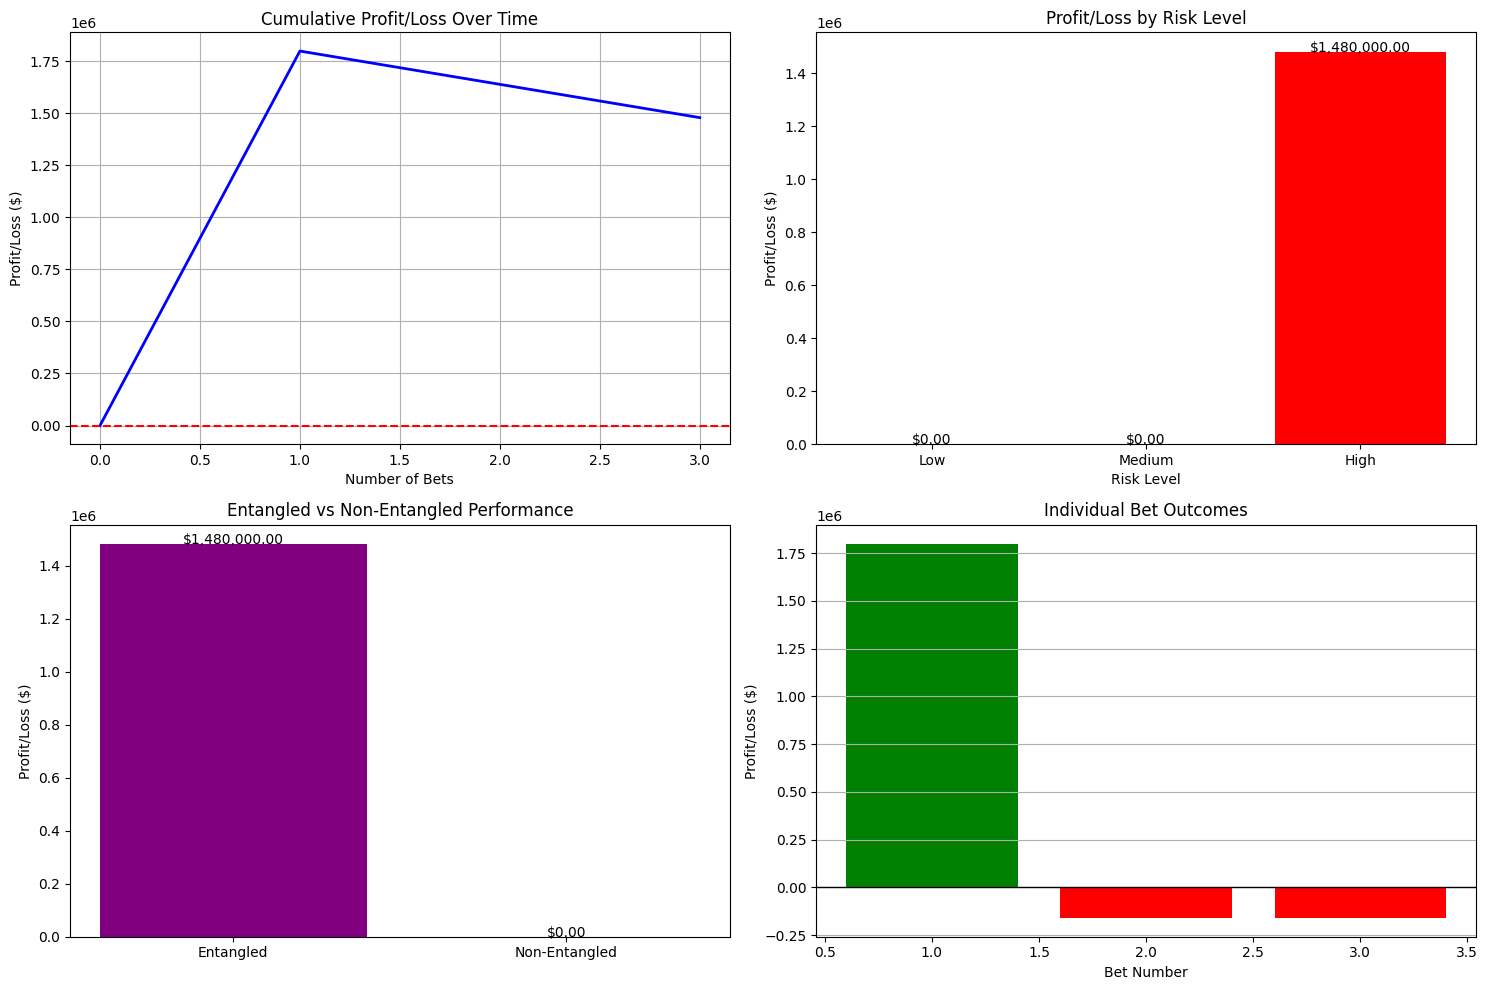


STRATEGY ANALYSIS
--------------------------------------------------
Best bet: $1,800,000.00 profit with High risk (Entangled: Yes)
Worst bet: $-160,000.00 with High risk (Entangled: Yes)

Performance by Risk Level:
  High Risk: $1,480,000.00 from 3 bets (Win Rate: 33.33%)

Performance by Entanglement:
  Entangled Balls: $1,480,000.00 from 3 bets (Win Rate: 33.33%)
Analysis Complete!


In [23]:
analyze_game_data()